# Calibrating the velocity field against observations 

In [22]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp
from numpyro.infer import MCMC, NUTS, init_to_median
import corner
from getdist import plots
from scipy.stats import multivariate_normal

import csiborgtools

from flow_calibration import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOS density & radial velocity plots 

In [28]:
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", [0], "LOSS", fpath, paths, ksmooth=0, )
# loaders_csiborg2X = [csiborgtools.flow.DataLoader("csiborg2X", i, "LOSS", fpath, paths, ksmooth=1, verbose=False) for i in range(20)]
# loaders_csiborg2 = [csiborgtools.flow.DataLoader("csiborg2_main", i, "LOSS", fpath, paths, ksmooth=1, verbose=False) for i in range(20)]

loader_CF4 = csiborgtools.flow.DataLoader("CF4gp", [0], "LOSS", fpath, paths, ksmooth=0, )

2024-06-27 14:51:05.432759:   reading the catalogue,
2024-06-27 14:51:05.440889:   reading the interpolated field,
2024-06-27 14:51:05.448475:   calculating the radial velocity.
2024-06-27 14:51:05.457636:   reading the catalogue,
2024-06-27 14:51:05.463423:   reading the interpolated field,
2024-06-27 14:51:05.469637:   calculating the radial velocity.


/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:91: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  warn(f"The number of radial steps is even. Skipping the first "


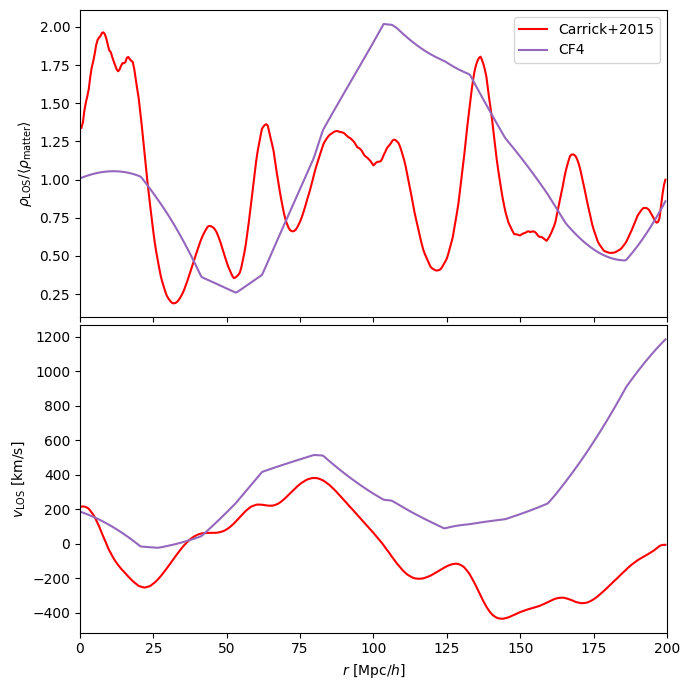

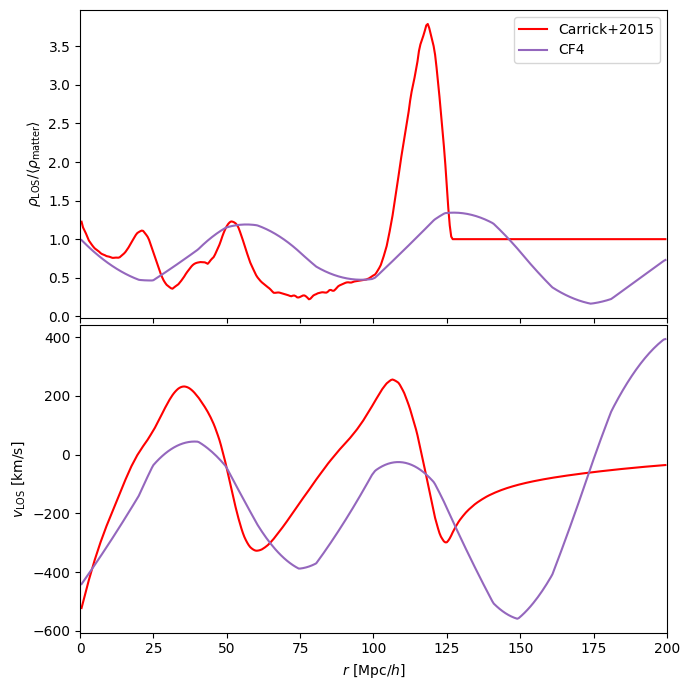

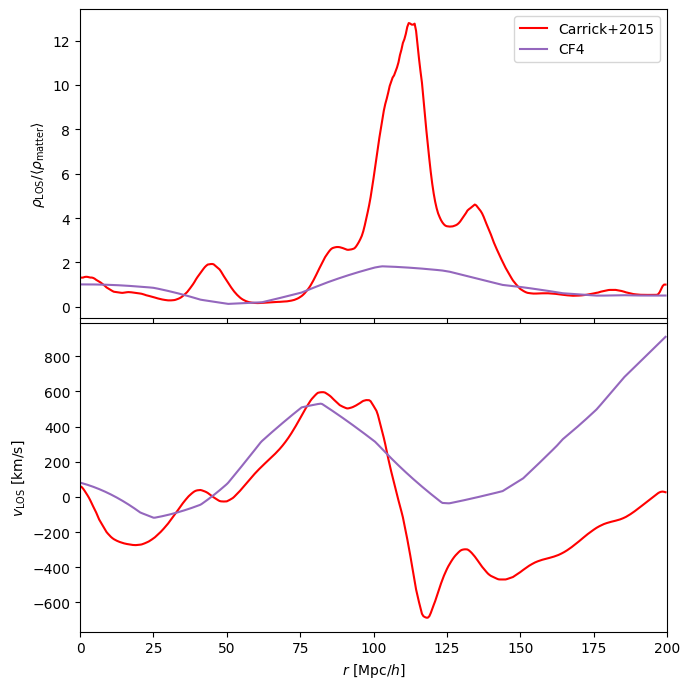

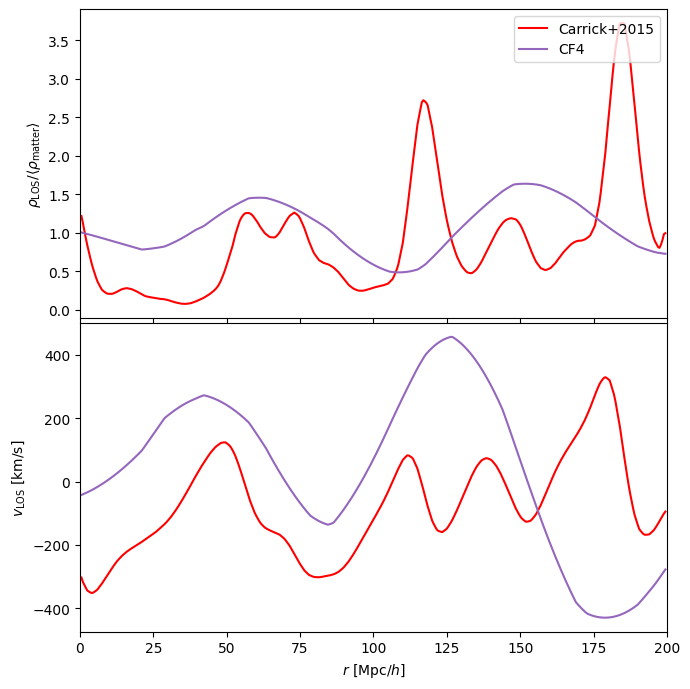

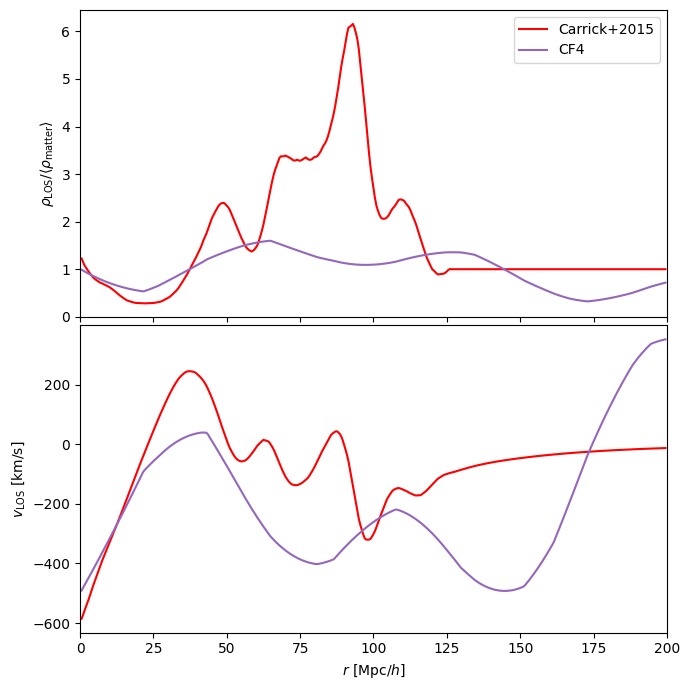

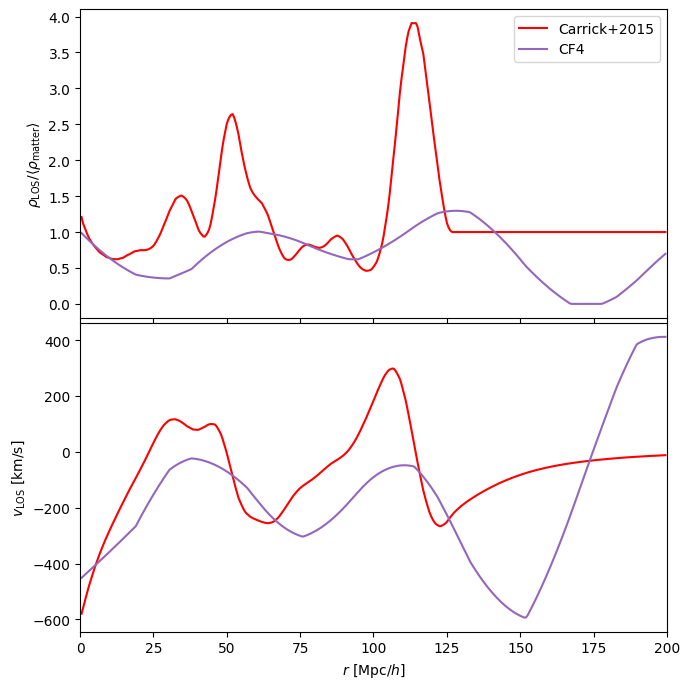

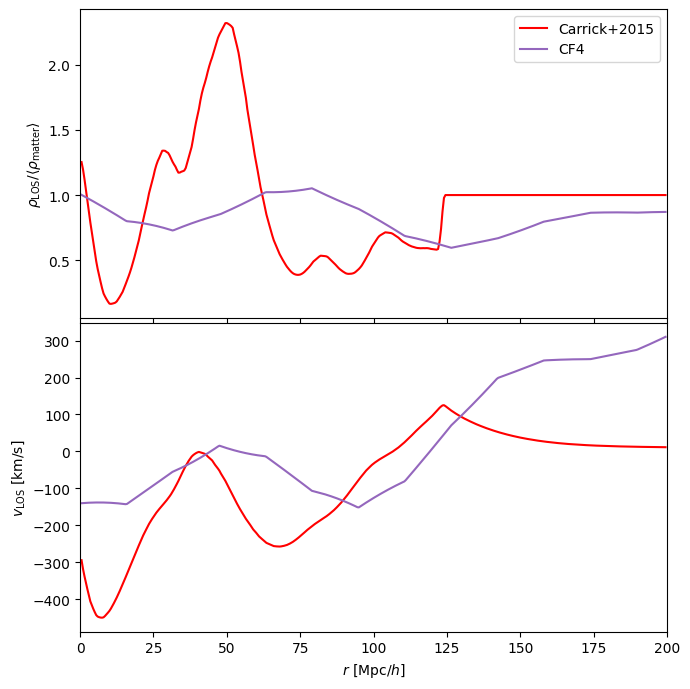

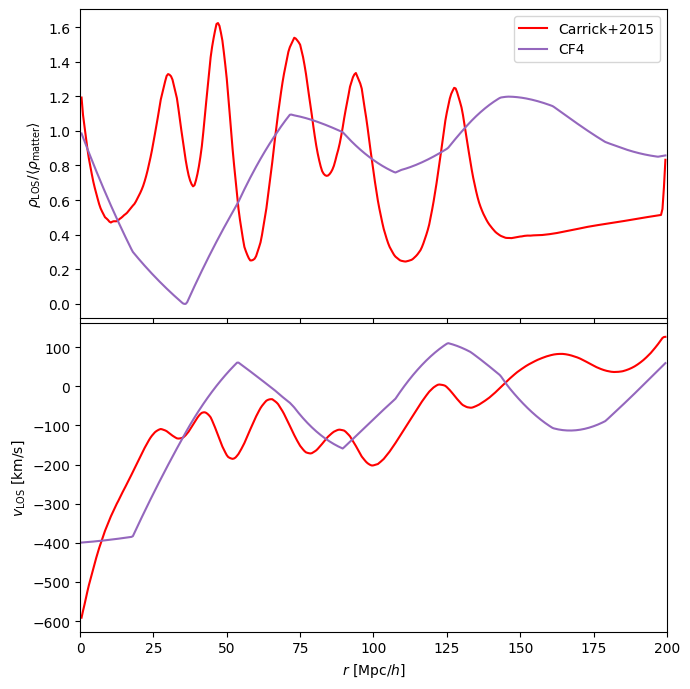

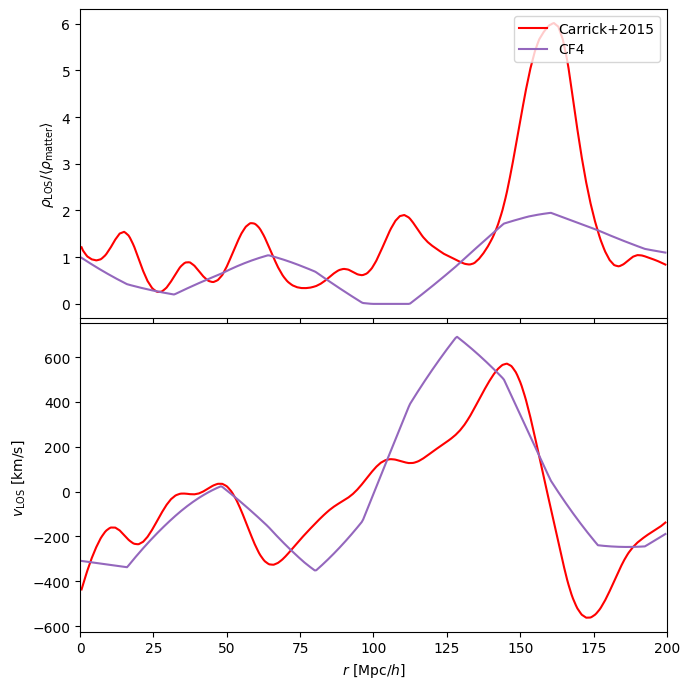

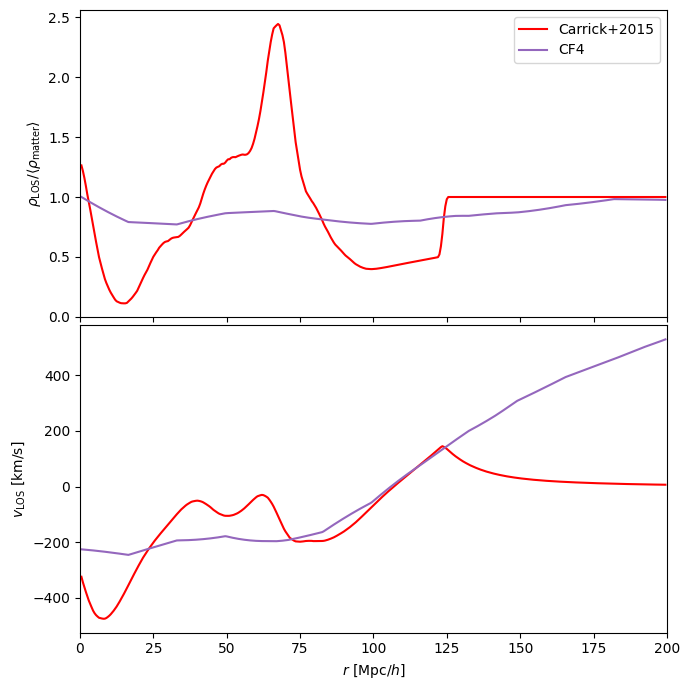

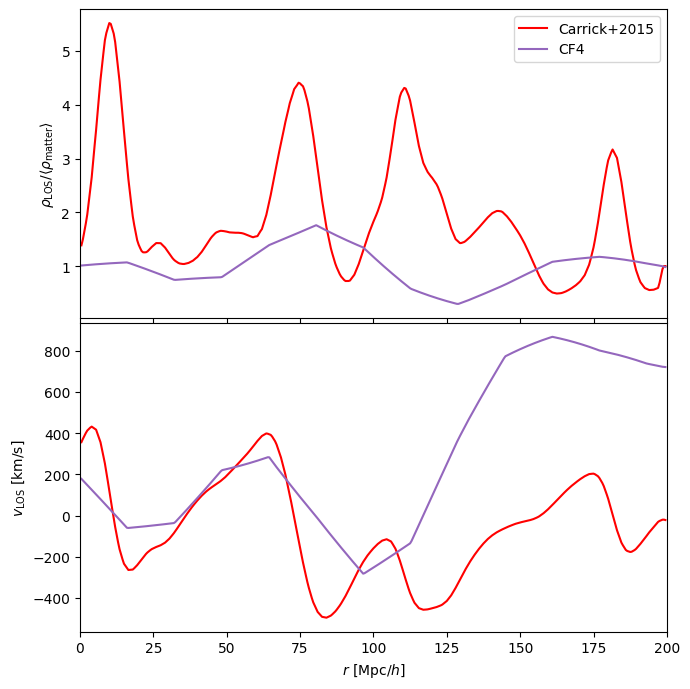

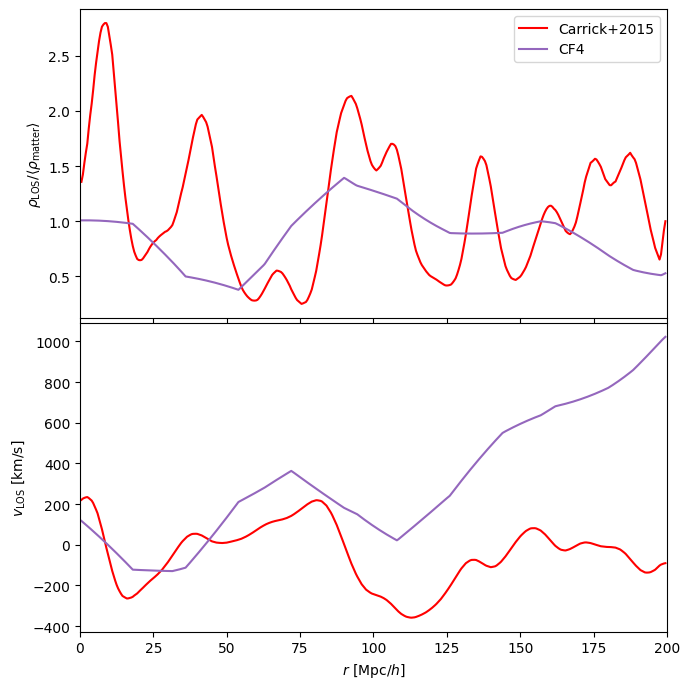

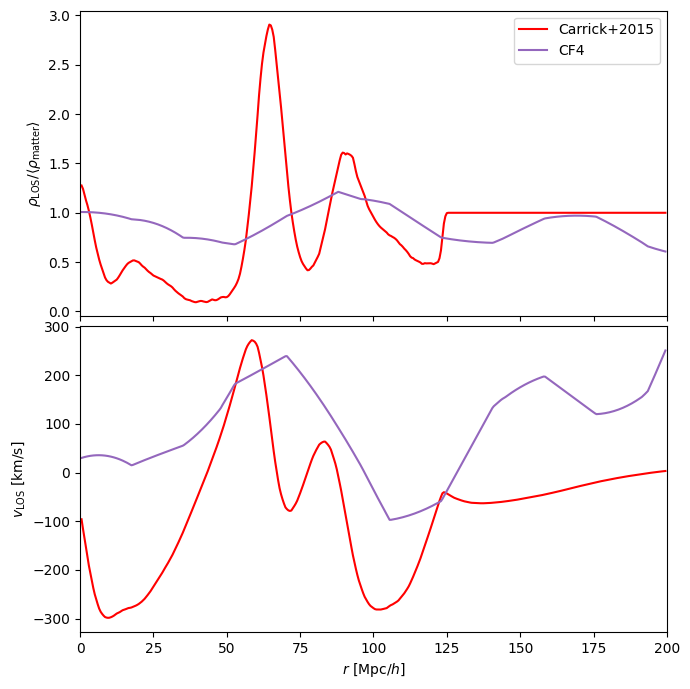

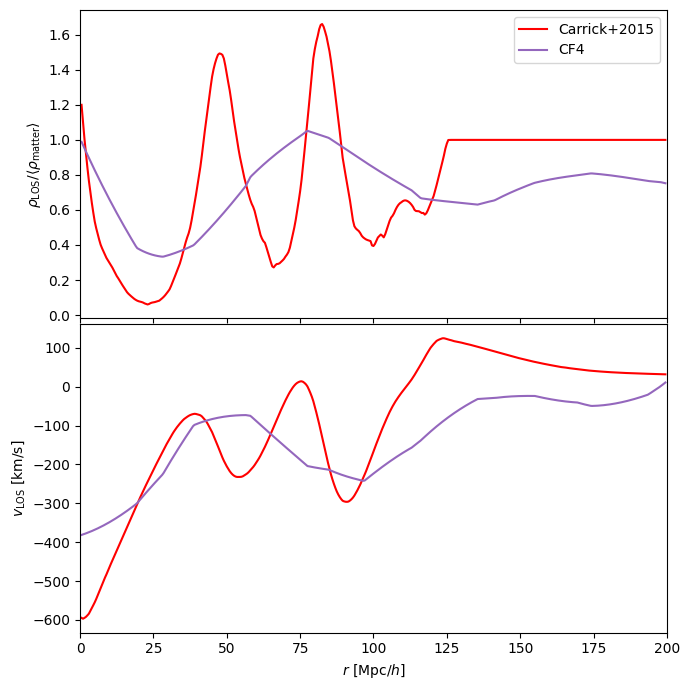

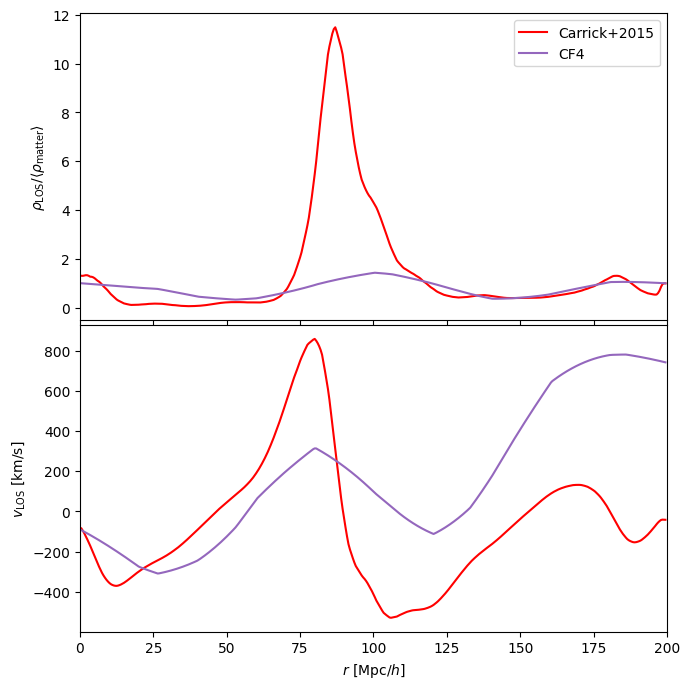

In [29]:
ks = [i for i in range(15)]
# ks = [0, 1, 2, 3, 4, 5, 6, ]

for k in ks:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    fig.subplots_adjust(wspace=0)
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # # CSiBORG2
    # x = loaders_csiborg2X[0].rdist
    # y = np.asarray([loaders_csiborg2[i].los_density[k, :] for i in range(len(loaders_csiborg2X))])
    # ylow, ymed, yhigh = np.percentile(y, [16, 50, 84], axis=0)
    # axs[0].fill_between(x, ylow, yhigh, color=cols[0], alpha=0.25)
    # axs[0].plot(x, ymed, color=cols[0], label="CSiBORG2")

    # y = np.asarray([loaders_csiborg2[i].los_radial_velocity[k, :] for i in range(len(loaders_csiborg2X))])
    # ylow, ymed, yhigh = np.percentile(y, [16, 50, 84], axis=0)
    # axs[1].fill_between(x, ylow, yhigh, color=cols[0], alpha=0.25)
    # axs[1].plot(x, ymed, color=cols[0], label="CSiBORG2")

    # # CSiBORG2X
    # x = loaders_csiborg2X[0].rdist
    # y = np.asarray([loaders_csiborg2X[i].los_density[k, :] for i in range(len(loaders_csiborg2X))])
    # ylow, ymed, yhigh = np.percentile(y, [16, 50, 84], axis=0)
    # axs[0].fill_between(x, ylow, yhigh, color=cols[1], alpha=0.25)
    # axs[0].plot(x, ymed, color=cols[1], label="CSiBORG2X")

    # y = np.asarray([loaders_csiborg2X[i].los_radial_velocity[k, :] for i in range(len(loaders_csiborg2X))])
    # ylow, ymed, yhigh = np.percentile(y, [16, 50, 84], axis=0)
    # axs[1].fill_between(x, ylow, yhigh, color=cols[1], alpha=0.25)
    # axs[1].plot(x, ymed, color=cols[1], label="CSiBORG2X")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[0, k, :], color="red", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[0, k, :] * 0.43, color="red")

    # Plot CF4
    c = cols[4]
    axs[0].plot(loader_CF4.rdist, loader_CF4.los_density[0, k, :], color=c, label="CF4")
    axs[1].plot(loader_CF4.rdist, loader_CF4.los_radial_velocity[0, k, :], color=c)


    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")
    # axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    # fig.savefig(f"../../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [19]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_mock_CB2_17417_large.hdf5"

simname = "CF4"
catalogue = "LOSS"
loader = csiborgtools.flow.DataLoader(simname, [0], catalogue, fpath_data, paths, ksmooth=0, )

SN_hyperparams = {"e_mu_mean": 0.1, "e_mu_std": 0.05, 
                  "mag_cal_mean": -18.25, "mag_cal_std": 0.5,
                  "alpha_cal_mean": 0.148, "alpha_cal_std": 0.05,
                  "beta_cal_mean": 3.112, "beta_cal_std": 1.0,
                  }
calibration_hyperparams = {"Vext_std": 250,
                           "alpha_mean": 1.0, "alpha_std": 0.5,
                           "beta_mean": 1.0, "beta_std": 0.5,
                           "sigma_v_mean": 150., "sigma_v_std": 100.,
                           "sample_alpha": True, "sample_beta": True,
                           }
get_model_kwargs = {"zcmb_max": 0.05}

2024-06-27 13:05:36.632317:   reading the catalogue,
2024-06-27 13:05:36.639136:   reading the interpolated field,
2024-06-27 13:05:36.646839:   calculating the radial velocity.


#### Running HMC

In [20]:
model = csiborgtools.flow.get_model(loader, **get_model_kwargs)
model_kwargs = {"distmod_hyperparams": SN_hyperparams, "calibration_hyperparams": calibration_hyperparams,}

Selected 50/50 galaxies.


In [21]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

rng_key = jax.random.PRNGKey(5)
mcmc.run(rng_key, extra_fields=("potential_energy",), **model_kwargs)
mcmc.print_summary()
samples = mcmc.get_samples()

warmup:   2%|▏         | 24/1000 [00:15<10:42,  1.52it/s, 1023 steps of size 1.33e-02. acc. prob=0.70]


KeyboardInterrupt: 

In [25]:
from numpyro.infer import log_likelihood

In [26]:
ll_single = log_likelihood(model, samples, **model_kwargs)["ll"]
ll_mult = log_likelihood(model_mult, samples, **model_kwargs, )["ll"]

In [27]:
ll_single - ll_mult

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Array([-374.78827, -376.5492 , -371.77686, -372.9841 , -378.55914,
       -378.39984, -378.2459 , -375.273  , -377.44177, -377.93024,
       -379.78754, -376.69867, -376.69543, -373.6802 , -378.27258,
       -375.40875, -375.0953 , -372.4082 , -378.23706, -373.86218,
       -378.33875, -376.94678, -373.83652, -378.32117, -378.96307,
       -376.3273 , -378.99994, -375.4494 , -377.64166, -375.86154,
       -378.59518, -380.15732, -377.50745, -380.40387, -376.8189 ,
       -376.1007 , -373.51187, -377.10147, -374.32153, -374.2683 ,
       -375.59872, -376.4356 , -377.2743 , -377.35114, -374.19208,
       -376.06555, -380.0948 , -374.54852, -377.23047, -382.89264,
       -380.85538, -378.4214 , -375.15735, -373.39212, -375.85846,
       -375.65417, -376.16678, -375.97055, -378.42426, -376.42603,
       -377.9259 , -372.40448, -373.42722, -374.55554, -378.3473 ,
       -373.24213, -374.04   , -374.16534, -374.32443, -379.45923,
       -375.31113, -378.57886, -375.84442, -377.4536 , -376.42

In [10]:
mcmc.get_extra_fields()["potential_energy"]

Array([391.9341 , 392.08212, 391.02206, 389.15616, 398.34534, 398.74045,
       394.00363, 394.9679 , 392.753  , 392.53403, 390.58237, 389.0428 ,
       390.0239 , 393.4534 , 392.26123, 390.88834, 389.4346 , 388.27728,
       388.42407, 390.7624 , 393.82834, 396.3672 , 393.64532, 392.78622,
       394.62543, 392.79187, 394.0692 , 394.19113, 393.68393, 393.9558 ,
       394.51782, 394.80338, 394.38104, 392.66638, 392.84058, 393.24478,
       394.0837 , 394.68433, 390.162  , 392.5648 , 390.56827, 394.7597 ,
       394.33154, 393.9468 , 391.83417, 394.58472, 394.23224, 391.1751 ,
       391.31418, 399.5129 , 394.8937 , 393.32156, 389.23395, 389.13815,
       389.2338 , 390.08365, 392.15442, 391.80756, 396.48865, 392.57013,
       392.00992, 392.81107, 391.49927, 391.80618, 395.6378 , 393.09927,
       392.07812, 389.32758, 391.35922, 393.24258, 393.46533, 391.42642,
       390.91577, 390.9773 , 389.37076, 392.87485, 393.59995, 393.8794 ,
       394.30118, 392.2907 , 390.15256, 390.99207, 

In [11]:
samples = mcmc.get_samples()
csiborgtools.numpyro_gof(model, mcmc)

(774.734619140625, 755.6143798828125)

In [117]:
data, names, __ = read_samples("LOSS", "Carrick2015", 0, return_MCsamples=False)


Reading LOSS fitted to Carrick2015 with ksmooth = 0.


BIC  = 773.225037 +- 0.000000
AIC  = 754.104797 +- 0.000000
logZ = -356.240234 +- 0.000000
chi2 = 1.207006 +- 0.228673


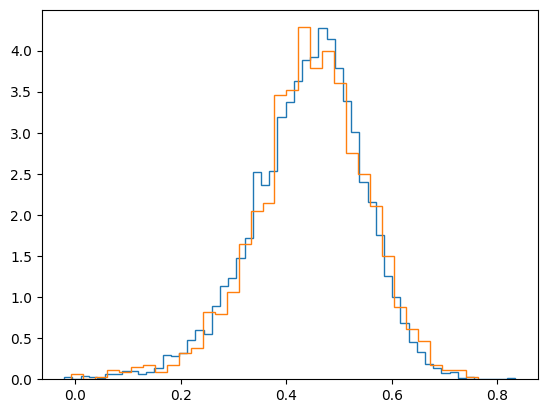

In [118]:
key = "beta"

plt.figure()
plt.hist(data[:, names.index(key)], bins="auto", density=1, histtype="step")
plt.hist(samples[key], bins="auto", density=1, histtype="step")

plt.show()

In [119]:
samples = mcmc.get_samples()

In [120]:
samples["ll_values"]

Array([-369.51086, -369.97043, -370.17526, ..., -372.54755, -376.03503,
       -374.88458], dtype=float32)

In [121]:
nparam = 0
for val in samples.values():
    if val.ndim == 1:
        nparam += 1
    elif val.ndim == 2:
        nparam += val.shape[-1]
    else:
        raise ValueError("Invalid dimensionality of samples to count the number of parameters.")
    

nparam
    
        

11

In [122]:
Vmag = np.sqrt(samples["Vext"][:, 0]**2 + samples["Vext"][:, 1]**2 + samples["Vext"][:, 2]**2)

V = np.vstack([samples["Vext"][:, 0], samples["Vext"][:, 1], samples["Vext"][:, 2]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.radec_to_galactic(V[:, 1], V[:, 2])

print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
if "beta" in samples:
    print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

|V|  = 197.8179931640625 +- 99.38513946533203
l    = 213.2463176948003 +- 116.2995226818662
b    = -5.31730133782022 +- 27.004291397137365
beta = 0.4450029134750366 +- 0.10768470168113708


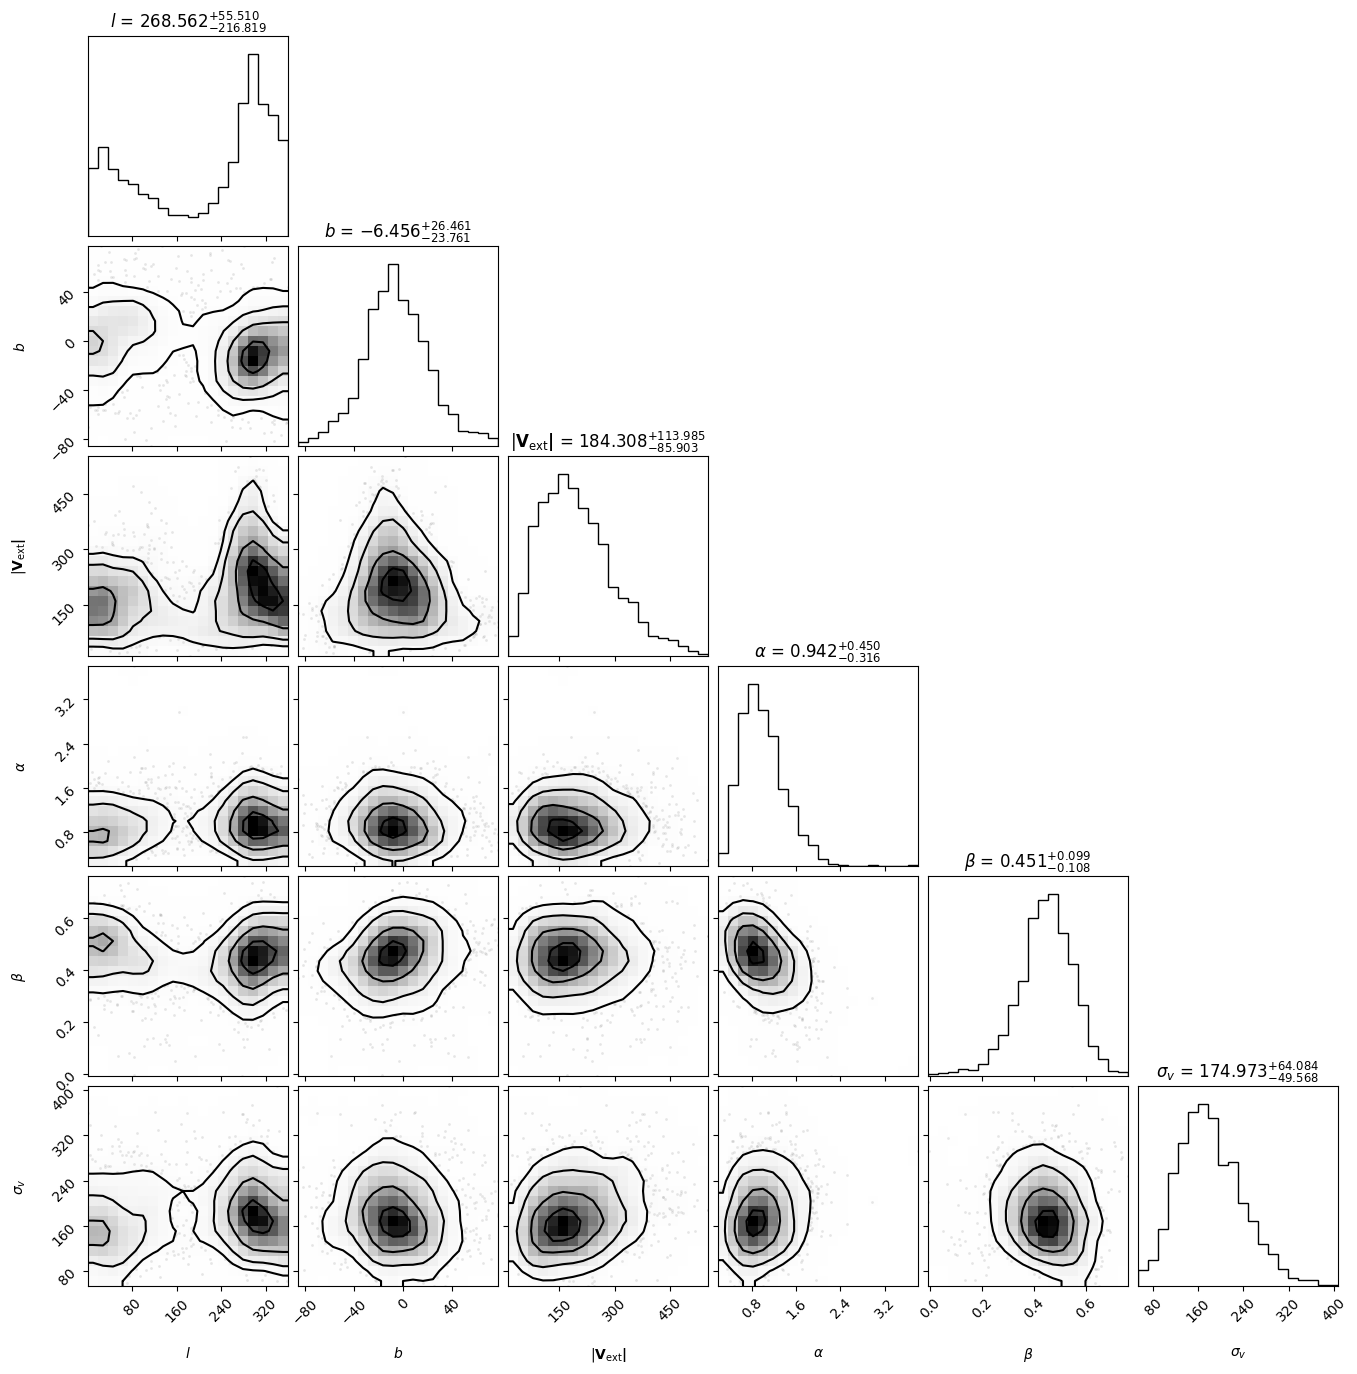

In [123]:
data = [l, b, Vmag]
labels = [r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
if "alpha" in samples:
    data.append(samples["alpha"])
    labels.append(r"$\alpha$")

if "beta" in samples:
    data.append(samples["beta"])
    labels.append(r"$\beta$")

if "h" in samples:
    data.append(samples["h"])
    labels.append(r"$h$")

if "sigma_v" in samples:
    data.append(samples["sigma_v"])
    labels.append(r"$\sigma_v$")

data = np.vstack(data).T
fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)
fig.savefig(f"../../plots/mock_{simname}_{catalogue}.png", dpi=500, bbox_inches="tight")

In [125]:
read_samples("Pantheon+", "csiborg2_main", 0, return_MCsamples=True)


Reading Pantheon+ fitted to csiborg2_main with ksmooth = 0.
BIC  = 10055.604150 +- 27.237237
AIC  = 10010.412744 +- 27.237237
logZ = -5000.136133 +- 23.062465
chi2 = 0.985968 +- 0.117400
Removed no burn in


## Vizualize the results

In [ ]:
data, names, gof = read_samples("Pantheon+_groups", "Carrick2015", 0)

fig = corner.corner(data, labels=names_to_latex(names, True), show_titles=True,
                    title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

### $\texttt{LOSS}$ comparison

In [126]:
LOSS_Carrick_0 = read_samples("LOSS", "Carrick2015", 0, return_MCsamples=True)
# LOSS_Carrick_1 = read_samples("LOSS", "Carrick2015", 1, return_MCsamples=True)

# LOSS_CB1_0 = read_samples("LOSS", "csiborg1", 0, return_MCsamples=True)
# LOSS_CB1_1 = read_samples("LOSS", "csiborg1", 1, return_MCsamples=True)

# LOSS_CB2_0 = read_samples("LOSS", "csiborg2_main", 0, return_MCsamples=True)
# LOSS_CB2_1 = read_samples("LOSS", "csiborg2_main", 1, return_MCsamples=True)


Reading LOSS fitted to Carrick2015 with ksmooth = 0.
BIC  = 773.225037 +- 0.000000
AIC  = 754.104797 +- 0.000000
logZ = -356.240234 +- 0.000000
chi2 = 1.207006 +- 0.228673
Removed no burn in


In [ ]:
X = [
     LOSS_Carrick_0,
     # LOSS_Carrick_1,
     # LOSS_CB1_0,
     LOSS_CB1_1,
     LOSS_CB2_0,
     LOSS_CB2_1,
     ]

# params = ["l", "b", "Vmag", "beta"]
params = None

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
g.export(f"../plots/LOSS_comparison.png", dpi=500,)


### $\texttt{Foundation}$ comparison

In [ ]:
FOUNDATION_Carrick_0 = read_samples("Foundation", "Carrick2015", 0, return_MCsamples=True)
FOUNDATION_Carrick_1 = read_samples("Foundation", "Carrick2015", 1, return_MCsamples=True)

FOUNDATION_CB1_0 = read_samples("Foundation", "csiborg1", 0, return_MCsamples=True)
FOUNDATION_CB1_1 = read_samples("Foundation", "csiborg1", 1, return_MCsamples=True)

FOUNDATION_CB2_0 = read_samples("Foundation", "csiborg2_main", 0, return_MCsamples=True)
FOUNDATION_CB2_1 = read_samples("Foundation", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    FOUNDATION_Carrick_0,
    # FOUNDATION_Carrick_1,
    # FOUNDATION_CB1_0,
    FOUNDATION_CB1_1,
    FOUNDATION_CB2_0,
    FOUNDATION_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/FOUNDATION_comparison.png", dpi=500,)

### $\texttt{Pantheon+}$ comparison

In [ ]:
PANTHEONP_Carrick_0 = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True)
PANTHEONP_Carrick_1 = read_samples("Pantheon+", "Carrick2015", 1, return_MCsamples=True)

# PANTHEONP_CB1_0 = read_samples("Pantheon+", "csiborg1", 0, return_MCsamples=True)
# PANTHEONP_CB1_1 = read_samples("Pantheon+", "csiborg1", 1, return_MCsamples=True)

PANTHEONP_CB2_0 = read_samples("Pantheon+", "csiborg2_main", 0, return_MCsamples=True)
PANTHEONP_CB2_1 = read_samples("Pantheon+", "csiborg2_main", 1, return_MCsamples=True)


In [ ]:
X = [
    PANTHEONP_Carrick_0,
    # PANTHEONP_Carrick_1,
    # PANTHEONP_CB1_0,
    # PANTHEONP_CB1_1,
    PANTHEONP_CB2_0,
    PANTHEONP_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
# g.export(f"../plots/PANTHEONP_comparison.png", dpi=500,)

### $\texttt{Pantheon+}$ groups

In [ ]:
LG = -1

PANTHEONP_Carrick = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG, )
PANTHEONP_Carrick_Groups = read_samples("Pantheon+_groups", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)
PANTHEONP_Carrick_Groups_zSN = read_samples("Pantheon+_groups_zSN", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)
PANTHEONP_Carrick_zSN = read_samples("Pantheon+_zSN", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)

# ksmooth = 1
# PANTHEONP_CB2 = read_samples("Pantheon+", "csiborg2_main", ksmooth, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEONP_CB2_Groups = read_samples("Pantheon+_groups", "csiborg2_main", ksmooth, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEONP_CB2_Groups_zSN = read_samples("Pantheon+_groups_zSN", "csiborg2_main", ksmooth, return_MCsamples=True, subtract_LG_velocity=LG)




In [ ]:
params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")


X = [
    PANTHEONP_Carrick,
    # PANTHEONP_Carrick_Groups,
    # PANTHEONP_Carrick_Groups_zSN,
    PANTHEONP_Carrick_zSN,
    # PANTHEONP_CB2,
    # PANTHEONP_CB2_Groups,
    # PANTHEONP_CB2_Groups_zSN,
    # CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../../plots/PANTHEON_GROUPS_Carrick_comparison_LG.png", dpi=500,)

### $\texttt{2MTF}$ comparison

In [24]:
TWOMTF_Carrick_0 = read_samples("2MTF", "Carrick2015", 0, return_MCsamples=True)
TWOMTF_Carrick_1 = read_samples("2MTF", "Carrick2015", 1, return_MCsamples=True)

TWOMTF_CB1_0 = read_samples("2MTF", "csiborg1", 0, return_MCsamples=True)
TWOMTF_CB1_1 = read_samples("2MTF", "csiborg1", 1, return_MCsamples=True)

TWOMTF_CB2_0 = read_samples("2MTF", "csiborg2_main", 0, return_MCsamples=True)
TWOMTF_CB2_1 = read_samples("2MTF", "csiborg2_main", 1, return_MCsamples=True)



Reading 2MTF fitted to Carrick2015 with ksmooth = 0.
BIC  = 19517.031250 +- 0.000000
AIC  = 19470.867188 +- 0.000000
logZ = -9731.227539 +- 0.000000
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading 2MTF fitted to Carrick2015 with ksmooth = 1.
BIC  = 19632.685547 +- 0.000000
AIC  = 19586.521484 +- 0.000000
logZ = -9788.892578 +- 0.000000
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading 2MTF fitted to csiborg1 with ksmooth = 0.
BIC  = 19922.607596 +- 33.988735
AIC  = 19876.443533 +- 33.988735
logZ = -9934.180538 +- 17.010780
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading 2MTF fitted to csiborg1 with ksmooth = 1.
BIC  = 19840.144473 +- 31.749545
AIC  = 19793.980411 +- 31.749545
logZ = -9891.951984 +- 16.078607
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading 2MTF fitted to csiborg2_main with ksmooth = 0.
BIC  = 19248.799609 +- 38.583873
AIC  = 19202.635547 +- 38.583873
logZ = -9598.394336 +- 19.251815
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading 2

In [ ]:
X = [
    TWOMTF_Carrick_0,
    # TWOMTF_Carrick_1,
    # TWOMTF_CB1_0,
    TWOMTF_CB1_1,
    TWOMTF_CB2_0,
    TWOMTF_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/2MTF_comparison.png", dpi=500,)

### $\texttt{SFI++ galaxies}$ comparison

In [ ]:
SFIGAL_Carrick_0 = read_samples("SFI_gals", "Carrick2015", 0, return_MCsamples=True)
SFIGAL_Carrick_1 = read_samples("SFI_gals", "Carrick2015", 1, return_MCsamples=True)

# SFIGAL_CB1_0 = read_samples("SFI_gals", "csiborg1", 0, return_MCsamples=True)
# SFIGAL_CB1_1 = read_samples("SFI_gals", "csiborg1", 1, return_MCsamples=True)

SFIGAL_CB2_0 = read_samples("SFI_gals", "csiborg2_main", 0, return_MCsamples=True)
SFIGAL_CB2_1 = read_samples("SFI_gals", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    SFIGAL_Carrick_0,
    # SFIGAL_Carrick_1,
    # SFIGAL_CB1_0,
    # SFIGAL_CB1_1,
    # SFIGAL_CB2_0,
    SFIGAL_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/SFI_gals_comparison.png", dpi=500,)

### $\texttt{SFI++ groups}$ comparison

In [ ]:
SFIGROUP_Carrick_0 = read_samples("SFI_groups", "Carrick2015", 0, return_MCsamples=True)
SFIGROUP_Carrick_1 = read_samples("SFI_groups", "Carrick2015", 1, return_MCsamples=True)

SFIGROUP_CB2_0 = read_samples("SFI_groups", "csiborg2_main", 0, return_MCsamples=True)
SFIGROUP_CB2_1 = read_samples("SFI_groups", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    SFIGROUP_Carrick_0,
    SFIGAL_Carrick_0,
    # SFIGROUP_Carrick_1,
    # SFIGROUP_CB2_0,
    # SFIGROUP_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/SFI_gals_vs_groups_comparison.png", dpi=500,)

### SN to TF comparison

In [ ]:
LG = 0

# PANTHEONP_Carrick = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG, )
# PANTHEONP_Groups_Carrick = read_samples("Pantheon+_groups", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG, )
# TWOMTF_Carrick = read_samples("2MTF", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)
# SFIGAL_Carrick = read_samples("SFI_gals", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)

k = 1
PANTHEONP_CB2 = read_samples("Pantheon+", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG, )
PANTHEONP_Groups_CB2 = read_samples("Pantheon+_groups", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG, )
TWOMTF_CB2 = read_samples("2MTF", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_CB2 = read_samples("SFI_gals", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)

In [ ]:

params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")


X = [
    # PANTHEONP_Carrick,
    # PANTHEONP_Groups_Carrick,
    # TWOMTF_Carrick,
    # SFIGAL_Carrick,
    PANTHEONP_CB2,
    PANTHEONP_Groups_CB2,
    TWOMTF_CB2,
    SFIGAL_CB2,
    CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
# g.export(f"../../plots/SN_TF_CB2_consistency.png", dpi=500,)

### Mock $\texttt{CB2}$ comparison

In [ ]:
SMALLMOCK_CB2_0 = read_samples("CB2_small", "csiborg2_main", 0, return_MCsamples=True)
SMALLMOCK_CB2_1 = read_samples("CB2_small", "csiborg2_main", 1, return_MCsamples=True)

LARGEMOCK_CB2_0 = read_samples("CB2_large", "csiborg2_main", 0, return_MCsamples=True)
LARGEMOCK_CB2_1 = read_samples("CB2_large", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    # SMALLMOCK_CB2_0,
    # SMALLMOCK_CB2_1,
    LARGEMOCK_CB2_0,
    LARGEMOCK_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/CB2_mocks_large.png", dpi=500,)

## External flow consistency

#### Carrick2015

In [ ]:
X = [
    # LOSS_Carrick_0,
    # FOUNDATION_Carrick_0,
    PANTHEONP_Carrick_0,
    TWOMTF_Carrick_0,
    SFIGAL_Carrick_0,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/Carrick2015_external_flow.png", dpi=500,)

#### CSiBORG1

In [ ]:
X = [
    # LOSS_CB1_1,
    # FOUNDATION_CB1_1,
    PANTHEONP_CB1_1,
    TWOMTF_CB1_1,
    # SFIGAL_CB1_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB1_external_flow.png", dpi=500,)

#### CSiBORG2

In [ ]:
X = [
    # LOSS_CB2_1,
    # FOUNDATION_CB2_1,
    PANTHEONP_CB2_1,
    TWOMTF_CB2_1,
    SFIGAL_CB2_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB2_external_flow.png", dpi=500,)

In [ ]:
k = 1
LG = 0

# Carrick
# LOSS_Carrick_LG = read_samples("LOSS", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# FOUNDATION_Carrick_LG = read_samples("Foundation", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_Carrick_LG = read_samples("Pantheon+", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_Carrick_LG = read_samples("2MTF", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_Carrick_LG = read_samples("SFI_gals", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGROUPS_Carrick_LG = read_samples("SFI_groups", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)


# # CSiBORG2
# LOSS_CB2_LG = read_samples("LOSS", "csiborg2_main", k, return_MCsamples=True,subtract_LG_velocity=LG)
# FOUNDATION_CB2_LG = read_samples("Foundation", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_CB2_LG = read_samples("Pantheon+", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_CB2_LG = read_samples("2MTF", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_CB2_LG = read_samples("SFI_gals", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGROUP_CB2_LG = read_samples("SFI_groups", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)

# # CSiBORG1
# LOSS_CB1_LG = read_samples("LOSS", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# FOUNDATION_CB1_LG = read_samples("Foundation", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_CB1_LG = read_samples("Pantheon+", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_CB1_LG = read_samples("2MTF", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# SFIGAL_CB1_LG = read_samples("SFI_gals", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)

In [ ]:
params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")

X = [
    # LOSS_Carrick_LG,
    # FOUNDATION_Carrick_LG,
    # PANTHEON_Carrick_LG,
    # TWOMTF_Carrick_LG,
    # SFIGAL_Carrick_LG,
    # SFIGROUPS_Carrick_LG,
    # LOSS_CB1_LG,
    # FOUNDATION_CB1_LG,
    # PANTHEON_CB1_LG,
    # TWOMTF_CB1_LG,
    # SFIGAL_CB1_LG,
    # LOSS_CB2_LG,
    # FOUNDATION_CB2_LG,
    # PANTHEON_CB2_LG,
    # TWOMTF_CB2_LG,
    SFIGAL_CB2_LG,
    SFIGROUP_CB2_LG,
    CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
# g.export(f"../plots/ALL_dipole.png", dpi=500,)